## Goal 
### Predict passenger survival (Survived) from tabular data.

## Imports and settings 

In [323]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


pd.set_option("display.max_colwidth", 120)

print("Python:", sys.version.split()[0])


Python: 3.13.3


## Load data & observation

In [326]:

df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')
print("Shape:", df_train.shape)
df_train.info()
df_train.describe()

Shape: (891, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Problems 
During Exploratory Data Analysis (EDA), I identified several issues that need to be handled before modeling:

1. Missing values in some categories (Age, Cabin, Embarked, Fare (in test data))

2. Noisy / Inconsistent columns

- Cabin: Mix of letters/numbers, too many NaNs → not usable directly.

- Ticket: Inconsistent formats (letters + numbers), duplicated tickets, not clean.

3. Categorical columns

- Sex: Needs encoding (male/female to 0/1).

- Pclass: Should be one-hot encoded for some models.

- Embarked: Categorical with missing values.

4.  Outliers / Skewed data

- Fare: Very skewed distribution with some extremely high values.

- Will need log transformation.

## Missing values in the dataset

In [302]:
def missing_report(ddf: pd.DataFrame) -> pd.DataFrame:
    m = ddf.isna().sum()
    out = pd.DataFrame({"missing": m, "pct": (m / len(ddf) * 100).round(2)})
    return out[out["missing"] > 0].sort_values("missing", ascending=False)

display(missing_report(df_train))
display(missing_report(df_test))

,missing,pct
Cabin,687,77.10
Age,177,19.87
Embarked,2,0.22


,missing,pct
Cabin,327,78.23
Age,86,20.57
Fare,1,0.24


## Preprocessing Steps 
1. Handle missing values and processing outliers 

2. Standartization and normalization

3. Data conversation 

4. Feature Engineering (FamilySize, HasCabin, Deck, LogFare, Title (from Name).)


### Impute Embarked with most common value (mode)

- Only a couple of rows have missing Embarked values

- I use the most common category (mode) from train data as the fill value for missing data

- Why use train’s most common value for test?
Because the model should only “learn” from the train data. If we calculate the mode from test, we’d be peeking into data the model shouldn’t see (data leakage). That’s why we take the most common Embarked value from train and use it for both train and test.

In [327]:
most_common = df_train['Embarked'].mode()[0]
df_train['Embarked'].fillna(most_common, inplace=True)

df_test['Embarked'].fillna(most_common, inplace=True)

df_train['Embarked'].value_counts(dropna=False)

C:\Users\46739\AppData\Local\Temp\ipykernel_22188\2984141835.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train['Embarked'].fillna(most_common, inplace=True)
C:\Users\46739\AppData\Local\Temp\ipykernel_22188\2984141835.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

F

Embarked
S    646
C    168
Q     77
Name: count, dtype: int64

## Handling the Age Column

- The Age column has many missing values (~177).
- To preserve age-related patterns, I will use passengers’ Title (from the Name column) as a grouping variable.
- Extract title (Mr, Mrs, Miss etc) which show us age, gender and social status (Title feature)
- Map unusual titles to "Other"
- Missing ages will be filled with the median age of passengers sharing the same Title (e.g., Mr, Mrs, Miss, Master).

In [328]:

df_train['Title'] = df_train['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
df_test['Title']  = df_test['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

title_map = {
    "Mr": "Mr", "Mrs": "Mrs", "Miss": "Miss", "Master": "Master"
}
df_train['Title'] = df_train['Title'].map(lambda t: title_map.get(t, "Other"))
df_test['Title']  = df_test['Title'].map(lambda t: title_map.get(t, "Other"))

<>:1: SyntaxWarning: invalid escape sequence '\.'
<>:2: SyntaxWarning: invalid escape sequence '\.'
<>:1: SyntaxWarning: invalid escape sequence '\.'
<>:2: SyntaxWarning: invalid escape sequence '\.'
C:\Users\46739\AppData\Local\Temp\ipykernel_22188\3067403751.py:1: SyntaxWarning: invalid escape sequence '\.'
  df_train['Title'] = df_train['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
C:\Users\46739\AppData\Local\Temp\ipykernel_22188\3067403751.py:2: SyntaxWarning: invalid escape sequence '\.'
  df_test['Title']  = df_test['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)


In [329]:
age_medians = df_train.groupby('Title')['Age'].median()

def fill_age(row):
    if pd.isna(row['Age']):
        return age_medians.get(row['Title'], df_train['Age'].median())
    else:
        return row['Age']

df_train['Age'] = df_train.apply(fill_age, axis=1)
df_test['Age']  = df_test.apply(fill_age, axis=1)


## Handling the Ticket Column

- The Ticket column has many inconsistencies (mix of numbers and letters) and does not provide clear, structured information.

- Some tickets are shared by multiple passengers, which could indicate family or group travel — but this information is already captured by feature FamilySize.

- Because of its noisy nature and limited predictive power, I will drop the raw Ticket column.

In [330]:
df = df_train.drop(columns=['Ticket'])
df = df_test.drop(columns=['Ticket'])

## Data conversation

### Convert data in Sex column 
- I will convert categorical values male/female to numerical format for the better performance from the model (for both train and test data)

In [331]:
def encode_sex(s): 
	if s == 'male': 
		return 0 
	elif s == 'female': 
		return 1 
df_train['Sex'] = df_train['Sex'].apply(encode_sex)
df_train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",1,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S,Mr
5,6,0,3,"Moran, Mr. James",0,30.0,0,0,330877,8.4583,NaN,Q,Mr
6,7,0,1,"McCarthy, Mr. Timothy J",0,54.0,0,0,17463,51.8625,E46,S,Mr
7,8,0,3,"Palsson, Master. Gosta Leonard",0,2.0,3,1,349909,21.0750,NaN,S,Master
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",1,27.0,0,2,347742,11.1333,NaN,S,Mrs
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",1,14.0,1,0,237736,30.0708,NaN,C,Mrs


In [332]:
def encode_sex(s): 
	if s == 'male': 
		return 0 
	elif s == 'female': 
		return 1 
df_test['Sex'] = df_test['Sex'].apply(encode_sex)
df_test.head(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,892,3,"Kelly, Mr. James",0,34.5,0,0,330911,7.8292,NaN,Q,Mr
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",1,47.0,1,0,363272,7.0000,NaN,S,Mrs
2,894,2,"Myles, Mr. Thomas Francis",0,62.0,0,0,240276,9.6875,NaN,Q,Mr
3,895,3,"Wirz, Mr. Albert",0,27.0,0,0,315154,8.6625,NaN,S,Mr
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,22.0,1,1,3101298,12.2875,NaN,S,Mrs
5,897,3,"Svensson, Mr. Johan Cervin",0,14.0,0,0,7538,9.2250,NaN,S,Mr
6,898,3,"Connolly, Miss. Kate",1,30.0,0,0,330972,7.6292,NaN,Q,Miss
7,899,2,"Caldwell, Mr. Albert Francis",0,26.0,1,1,248738,29.0000,NaN,S,Mr
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",1,18.0,0,0,2657,7.2292,NaN,C,Mrs
9,901,3,"Davies, Mr. John Samuel",0,21.0,2,0,A/4 48871,24.1500,NaN,S,Mr



### Handling the Pclass Column
- The Pclass column represents passenger class (1st, 2nd, 3rd). It is categorical, for linear models it’s safer to one-hot encode Pclass. 
- I will create three separate binary columns
- I keep Pclass_raw data for EDA

In [333]:
df_train["Pclass_raw"] = df_train["Pclass"]

df_train = pd.get_dummies(df_train, columns=['Pclass'], prefix='Pclass')
df_test  = pd.get_dummies(df_test, columns=['Pclass'], prefix='Pclass')



## Engineering features

### Handling the Cabin Column (HasCabin, Deck features)

- The Cabin column has many missing values (~77%), so keeping the raw data is not useful for the model.

- To still capture useful information, I will create a new binary feature HasCabin (1 if Cabin is present, 0 otherwise).

- Additionally, I will extract the deck letter (first character of the cabin, e.g., A, B, C…) into a new column, and assign Unknown for missing values.

- I will keep the raw Cabin column for reference, but it will not be used as a model feature.

In [334]:
df_train['hasCabin'] = df_train['Cabin'].notna().astype(int)
df_train['Deck'] = df_train['Cabin'].str[0].fillna('Unknown')
df_train[['hasCabin', 'Deck']].head(7)

,hasCabin,Deck
0,0,Unknown
1,1,C
2,0,Unknown
3,1,C
4,0,Unknown
5,0,Unknown
6,1,E


In [335]:
df_test['hasCabin'] = df_test['Cabin'].notna().astype(int)
df_test['Deck'] = df_test['Cabin'].str[0].fillna('Unknown')
df_test[['hasCabin', 'Deck']].head(20)

,hasCabin,Deck
0,0,Unknown
1,0,Unknown
2,0,Unknown
3,0,Unknown
4,0,Unknown
5,0,Unknown
6,0,Unknown
7,0,Unknown
8,0,Unknown
9,0,Unknown


### Title feature  (look above at the Age column adjestments)
- Extract title (Mr, Mrs, Miss etc) which show us age, gender and social status 
- Map unusual titles to "Other"

### Age_category feature 

- Creare age categories: child 0-17, adult 18-59, senior 60-100

In [336]:
def apply_ageCategory(age):
    if pd.isna(age):
        return 'Unknown'
    elif 0 <= age <= 17:
        return 'Child'
    elif 18 <= age <= 59:
        return 'Adult'
    else:
        return 'Senior'


df_train['Age_category'] = df_train['Age'].apply(apply_ageCategory)
df_test['Age_category'] = df_test['Age'].apply(apply_ageCategory)

### Create FamilySize feature  

- FamilySize = SibSp + Parch + 1 (the +1 includes the passenger themselves).

- This feature may help the model, because survival chances could depend on whether someone traveled alone or with family.

In [337]:
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch'] + 1
df_train['FamilySize'].value_counts(dropna=False)

FamilySize
1     537
2     161
3     102
4      29
6      22
5      15
7      12
11      7
8       6
Name: count, dtype: int64

### Handling the Fare Column (LogFare feature)

- The Fare column represents the ticket price paid by a passenger.

- It has a wide range (from 0 up to 512).

- A few tickets are duplicated because passengers often shared a ticket (families or groups).

- I apply a log transformation (LogFare = log1p(Fare)) to reduce the effect of extreme values and make the distribution more balanced. Taking the log “compresses” the big numbers and spreads out the small ones that makes the distribution more balanced.

- I will keep both raw Fare and engineered LogFare


In [338]:

fare_median = df_train['Fare'].median()
df_train['Fare'].fillna(fare_median, inplace=True)
df_test['Fare'].fillna(fare_median, inplace=True)

df_train['LogFare'] = np.log1p(df_train['Fare'])
df_test['LogFare']  = np.log1p(df_test['Fare'])

df_train[['Fare', 'LogFare']].head()


C:\Users\46739\AppData\Local\Temp\ipykernel_22188\4053983729.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train['Fare'].fillna(fare_median, inplace=True)
C:\Users\46739\AppData\Local\Temp\ipykernel_22188\4053983729.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For e

,Fare,LogFare
0,7.2500,2.110213
1,71.2833,4.280593
2,7.9250,2.188856
3,53.1000,3.990834
4,8.0500,2.202765


In [317]:
df_train.head(4)

,PassengerId,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,Title,Pclass_raw,Pclass_1,Pclass_2,Pclass_3,hasCabin,Deck,Age_category,FamilySize,LogFare
0,1,0,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,...,Mr,3,False,False,True,0,Unknown,Adult,2,2.110213
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",1,38.0,1,0,PC 17599,71.2833,C85,...,Mrs,1,True,False,False,1,C,Adult,2,4.280593
2,3,1,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,...,Miss,3,False,False,True,0,Unknown,Adult,1,2.188856
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,...,Mrs,1,True,False,False,1,C,Adult,2,3.990834


## Visualisation

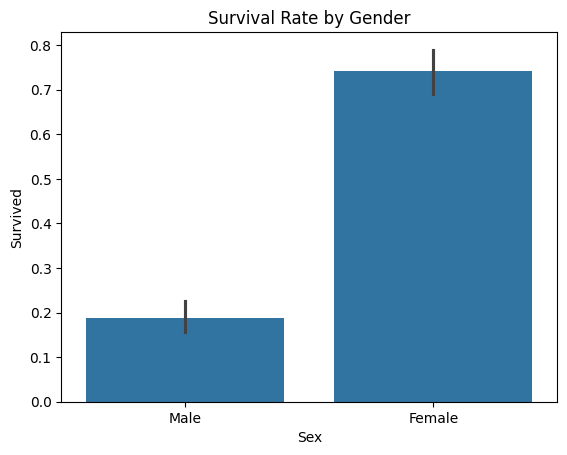

In [318]:
sns.barplot(x="Sex", y="Survived", data=df_train)
plt.title("Survival Rate by Gender")
plt.xticks([0, 1], ["Male", "Female"])
plt.show()

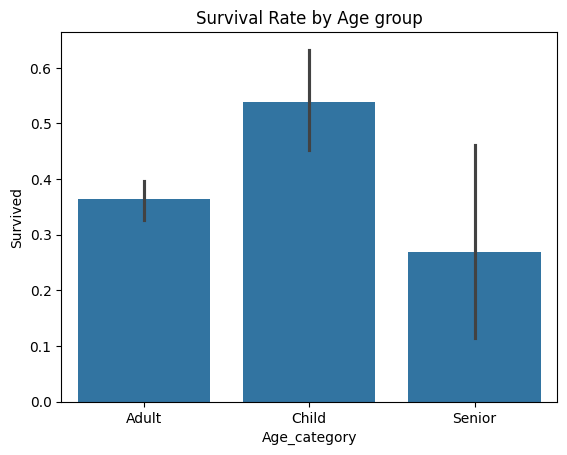

In [319]:
sns.barplot(x="Age_category", y="Survived", data=df_train)
plt.title("Survival Rate by Age group")
plt.show()

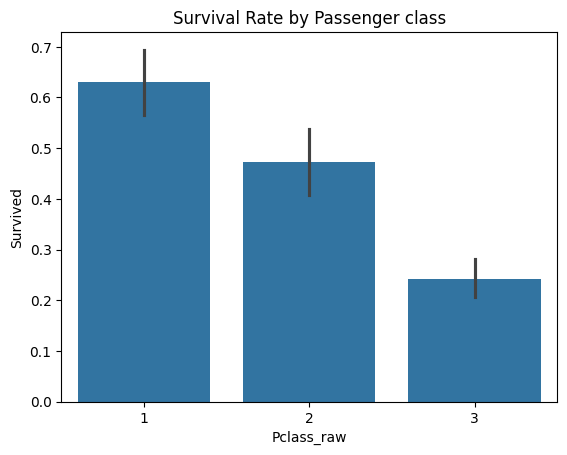

In [322]:
sns.barplot(x="Pclass_raw", y="Survived", data=df_train)
plt.title("Survival Rate by Passenger class")
plt.show()

## Create a Model (Logistic regression)

### 1. Split into Features and Target

In [284]:
features = ['Sex', 'Age', 'LogFare', 'FamilySize', 'hasCabin', 'Pclass_1', 'Pclass_2', 'Pclass_3']
X_train = df_train[features]
y_train = df_train['Survived']
X_test  = df_test[features]

In [288]:

model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [290]:
y_test_pred = model.predict(X_test)

In [291]:
submission = pd.DataFrame({
    "PassengerId": df_test["PassengerId"],
    "Survived": y_test_pred
})
submission.to_csv("submission.csv", index=False)
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


## Create a K-Nearest Neighbors Model 

In [342]:
features = ["Sex", "Age", "Fare", "FamilySize", "Pclass_1", "Pclass_2", "Pclass_3"]
X = df_train[features]
y = df_train["Survived"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

model_knn = KNeighborsClassifier(n_neighbors=10)
model_knn.fit(X_train, y_train)

y_pred = model_knn.predict(X_test)

print("Validation Accuracy:", accuracy_score(y_test, y_pred))

Validation Accuracy: 0.6927374301675978
